# Exploring RNN architectures for Quantum state representation

A couple types of rnn:
    
    Gru
    
    Lstm
    
    2D lstm (if we have a 2d input)
    
    Tranformer (masked) (masked makes it causal whereas unmasked would be non causal)
    
Extra networks:

    Echo state networks  -> look into
    
    Resevoir computing cells -> look into
        
        Apparently you only train the output weights -> avoids a bunch of backprop
        
        but we use it in a recurrent fashion so you need to backprop still
        
        Look at BYOL for this (might not be possible)
    
    

# Quantum state to represent

- Start with Rydberg system

Transverse and longitudinal view of ising model

Excited state encourages nearby (within radius $R_b$)states to tend towards ground states

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math,time
import torch
from torch import nn
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
from numba import cuda

cuda:0


# Simple RNN to start


In [2]:
class RNN(nn.Module):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    def __init__(self,rnntype="GRU",device=device, **kwargs):
        super(RNN, self).__init__()
        #rnn takes input shape [B,L,1]
        
        
        self.rnn = RNN.TYPES[rnntype](input_size=1,hidden_size=128,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        
        self.rnntype=rnntype
        self.device=device
        self.to(device)
    def forward(self, input):
        # h0 is shape [d*numlayers,B,H] but D=numlayers=1 so
        # h0 has shape [1,B,H]
        
        if self.rnntype=="LSTM":
            h0=[torch.zeros([1,input.shape[0],128]).to(device),
               torch.zeros([1,input.shape[0],128]).to(device)]
            #h0 and c0
        else:
            h0=torch.zeros([1,input.shape[0],128]).to(device)
        out,h=self.rnn(input,h0)
        return self.lin(out)
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one]).to(self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you muptiply your conditional probability by pred[i]
        #if real[i]=0 than you muliply by 1-pred[i]
        
        #probability predictions should be done WITH gradients
        #with torch.no_grad():
        
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        logp=torch.sum(torch.log(total),dim=1).squeeze(1)
        return logp
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        if self.rnntype=="LSTM":
            h=[torch.zeros([1,B,128]).to(device),
               torch.zeros([1,B,128]).to(device)]
            #h is h0 and c0
        else:
            h=torch.zeros([1,B,128]).to(device)
        #Sample set will have shape [N,L,1]
        #need one extra zero batch at the start for first pred hence input is [N,L+1,1] 
        input = torch.zeros([B,L+1,1],device=device)
        #sampling can be done without gradients
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]
            
            out,h=self.rnn(input[:,idx-1:idx,:],h)
            out=out[:,0,:]
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(out)
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[:,idx,:]=sample
        #input's first entry is zero to get a predction for the first atom
        return input[:,1:,:]
    
    def sample_with_labels(self,B,L,grad=False):
        """Inputs:
            B (int) - The number of states to generate in parallel
            L (int) - The length of generated vectors
            grad (boolean) - Whether or not to use gradients
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logppl - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i+B*j] had one spin flipped at position j
                    relative to s[i]
        """
        sample=self.sample(B,L)
        sflip = torch.zeros([B,L,L,1],device=device)
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:,j] = sample*1.0
            sflip[:,j,j] = 1-sflip[:,j,j]
        #compute all of their logscale probabilities
        if not grad:
            with torch.no_grad():
                probs = self.logprobability(sflip.view([B*L,L,1]))
        else:
            probs = self.logprobability(sflip.view([B*L,L,1]))
            
        #might make sflip shape [B,L] in the future
        return sample,probs.reshape([B,L])

In [3]:
@cuda.jit
def Vij(Ly,Lx,Rcutoff,V,matrix):
    #matrix will be size [Lx*Ly,Lx*Ly]
    
    i,j=cuda.grid(2)
    if i>Ly or j>Lx:
        return
    R=Rcutoff**6
    #flatten two indices into one
    idx = Ly*j+i
    # only fill in the upper diagonal
    for k in range(idx+1,Lx*Ly):
        #expand one index into two
        i2 = k%Ly
        j2=k//Ly
        div = ((i2-i)**2+(j2-j)**2)**3
        if div<=R:
            matrix[idx][k]=V/div
    

class Hamiltonian():
    def __init__(self,Lx,Ly,V,Omega,delta,R=2.01,device=device):
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.Omega    = Omega           # Rabi frequency
        self.delta    = delta           # Detuning
        self.L        = Lx * Ly         # Number of spins
        self.device   = device
        self.R=R
        self.buildlattice()
        
    def buildlattice(self):
        Lx,Ly=self.Lx,self.Ly
        
        #diagonal hamiltonian portion can be written as a matrix multiplication then a dot product
        self.Vij=nn.Linear(self.L,self.L).to(device)
        
        mat=np.zeros([self.L,self.L])
        
        Vij[(1,1),(Lx,Ly)](Lx,Ly,self.R,self.V,mat)
        with torch.no_grad():
            self.Vij.weight[:,:]=torch.Tensor(mat)
            self.Vij.bias.fill_(-self.delta)
        
    def localenergy(self,samples,logp,logppj):
        """
        Takes in s, ln[p(s)] and ln[p(1-s)], then computes Hloc(s) for N samples s.
        
        Inputs:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logp - size B vector of logscale probabilities ln[p(s)]
            logppl - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i+B*j] had one spin flipped at position j
                    relative to s[i]
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B).to(self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        #flip ONE spin here and get sqrt(p(s)/p(s'))
        #then sum over all spin flips
        #think of ways to cheat
        
        #logppj is shape [B*L]
        # the first N labels in logppj are the log probabilities for
        # the N states but with the first state flipped (ground-> excited and excited-> ground)
        # the second N all were calculated with only the second state flipped 
        # etc...
        for j in range(self.L):
            #logpflip is log(p(1-s))
            #logp is log(p(s))?
            #s' has one spin flipped at j
            #with psi(s)=sqrt(p(s)), sigma_i^x = psi(s')/psi(s)?
            
            #make sure torch.exp is a thing
            eloc += -0.5*self.Omega * torch.exp((logppj[:,j]-logp)/2)

        return eloc


In [4]:
testrnn = RNN(rnntype="LSTM")
print(testrnn.rnntype)
x=torch.zeros([10,4*4,1]).to(device)
print(testrnn(x).shape)
sample = testrnn.sample(10,4*4)
print(sample.shape)

sample,pflip = testrnn.sample_with_labels(10,4*4,grad=False)
logp=testrnn.logprobability(sample)
print(sample.shape,pflip.shape)
print(logp[0],'\n',pflip[::10])

print(testrnn)

LSTM
torch.Size([10, 16, 1])
torch.Size([10, 16, 1])
torch.Size([10, 16, 1]) torch.Size([10, 16])
tensor(-11.0360, device='cuda:0', grad_fn=<SelectBackward0>) 
 tensor([[-10.9793, -11.0976, -10.9789, -11.0958, -11.0942, -11.0935, -11.0938,
         -11.0950, -11.0977, -10.9750, -10.9731, -10.9732, -11.1029, -10.9740,
         -10.9747, -11.1000]], device='cuda:0')
RNN(
  (rnn): LSTM(1, 128, batch_first=True)
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [5]:
def new_rnn_with_optim(rnntype,lr=1e-3,beta1=0.9,beta2=0.999):
    rnn = RNN(rnntype=rnntype)
    optimizer = torch.optim.Adam(
    rnn.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
    )
    return rnn,optimizer

In [6]:
# Hamiltonian parameters
Lx = 4      # Linear size in x direction
Ly = 4      # Linear size in y direction
N = Lx*Ly   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

h = Hamiltonian(Lx,Ly,V,Omega,delta)


In [7]:
bsize=512

testrnn,optimizer=new_rnn_with_optim("LSTM")

# Regular training

In [8]:
t=time.time()
losses=[]
for x in range(1000):
    
    
    
    sample,pflip = testrnn.sample_with_labels(bsize,Lx*Ly,grad=False)    
    logp=testrnn.logprobability(sample)
    #sample = testrnn.sample(bsize,Lx*Ly)
    with torch.no_grad():
        E=h.localenergy(sample,logp,pflip)
        #E = h.LE2(sample,testrnn)
        Eo=E.mean()
        
    loss = (E*logp - Eo*logp).mean()
    
    ERR  = Eo/(Lx*Ly)
    testrnn.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(ERR.cpu().item())
print(time.time()-t)

25.523475885391235


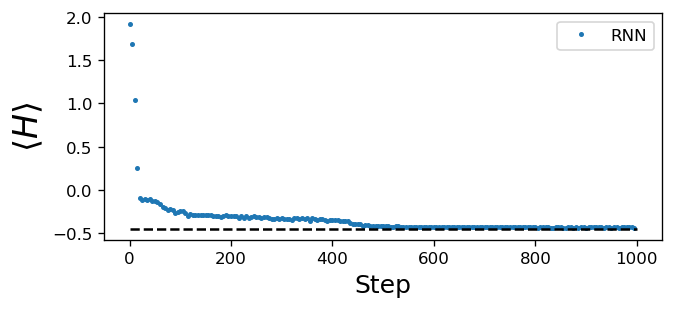

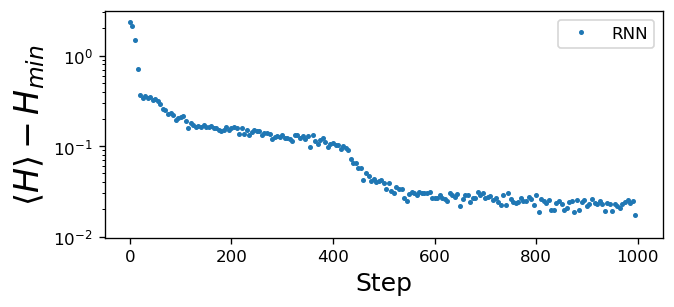

In [9]:
# Exact energy from exact diagonalization
exact_energy = -0.45776822

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(losses,marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.plot([0,1000],[exact_energy,exact_energy],'k--')

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")

plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(abs(np.array(losses)-exact_energy),marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.yscale("log")
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")

plt.show()

In [10]:
losses[-1]-exact_energy

0.022539693407745365

In [11]:
testrnn,optimizer=new_rnn_with_optim("LSTM")

# Training with Memory Queue

In [12]:
i=0
samplequeue,pflipqueue=testrnn.sample_with_labels(bsize,Lx*Ly,grad=True)

BlockNum=(Lx*Ly)//2

BbyL=bsize//BlockNum

print(BbyL*BlockNum)


t=time.time()
losses=[]
for x in range(2000):
    
    
    sample,pflip = testrnn.sample_with_labels(BbyL,Lx*Ly,grad=False)
    with torch.no_grad():
        samplequeue[i*BbyL:(i+1)*BbyL]=sample
        pflipqueue[i*BbyL:(i+1)*BbyL]=pflip
    i=(i+1)%BlockNum
    
    logp=testrnn.logprobability(samplequeue)
    
    
    #sample = testrnn.sample(bsize,Lx*Ly)
    
    
    with torch.no_grad():
        E=h.localenergy(samplequeue,logp,pflipqueue)
        #E = h.LE2(sample,testrnn)
        Eo=E.mean()
            
    loss = (E*logp - Eo*logp).mean()
    
    ERR  = Eo/(Lx*Ly)
    testrnn.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(ERR.cpu().item())
print(time.time()-t)

512
26.090375423431396


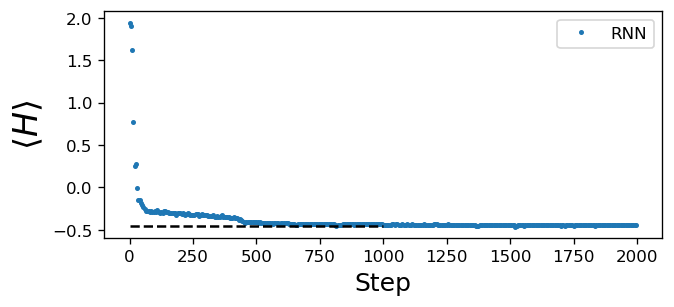

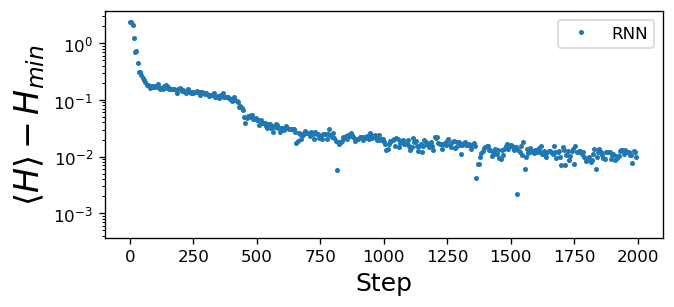

In [13]:
# Exact energy from exact diagonalization
exact_energy = -0.45776822

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(losses,marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.plot([0,1000],[exact_energy,exact_energy],'k--')

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")

plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(abs(np.array(losses)-exact_energy),marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.yscale("log")
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")

plt.show()

In [14]:
OUTsample,OUTpflip = testrnn.sample_with_labels(bsize,Lx*Ly,grad=False)    
OUTlogp=testrnn.logprobability(OUTsample)
#sample = testrnn.sample(bsize,Lx*Ly)
with torch.no_grad():
    OUTE=h.localenergy(OUTsample,OUTlogp,OUTpflip)
    #E = h.LE2(sample,testrnn)
    OUTEo=OUTE.mean()
    
print((OUTEo/(Lx*Ly)).cpu().item()-exact_energy)

0.012322742037506107


In [15]:
logp.shape
E.shape


torch.Size([512])

In [16]:
sample.squeeze(2).shape

torch.Size([64, 16])

In [17]:
x=torch.arange(27).reshape(3,3,3)